In [1]:
import numpy as np
import pandas as pd
import os
import math as m
import matplotlib.pyplot as plt
import time

## Import Data Functions

In [2]:
df = pd.read_csv(r"..\data\dataset_new_score_v3.csv").drop(columns="Unnamed: 0")
df.columns

Index(['titre', 'budget', 'recette', 'duree', 'realisateur', 'casting',
       'compagnies_production', 'suite', 'Comedy', 'Drama', 'Horror',
       'Thriller', 'Action', 'Adventure', 'Science Fiction', 'Fantasy',
       'Family', 'Crime', 'Romance', 'Animation', 'Mystery', 'War', 'Music',
       'Western', 'History', 'Documentary', 'TV Movie', 'benefice global',
       'saison', 'casting_score_sum', 'casting_score_mean',
       'casting_score_med', 'casting_score_min', 'casting_score_max',
       'director_score_sum', 'director_score_mean', 'director_score_med',
       'director_score_min', 'director_score_max', 'compagnies_score_sum',
       'compagnies_score_mean', 'compagnies_score_med', 'compagnies_score_min',
       'compagnies_score_max'],
      dtype='object')

## Datasets and Scaling

In [17]:
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.9
 
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=["titre", "recette", "realisateur", "casting", "compagnies_production", "benefice global",'director_score_mean', 'director_score_med',
       'director_score_min', 'director_score_max', 'compagnies_score_mean', 'compagnies_score_med', 'compagnies_score_min',
       'compagnies_score_max']), df["benefice global"], test_size = TEST_RATIO, shuffle=True, random_state = 1)

In [18]:
from sklearn.preprocessing import StandardScaler

X_train_f = StandardScaler().fit(np.array(X_train)).transform(np.array(X_train))


X_test_f = StandardScaler().fit(np.array(X_test)).transform(np.array(X_test))

print("Done")

Done


## Model

In [19]:
from sklearn.ensemble import RandomForestRegressor

start = time.time()
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train_f, Y_train)
end = time.time()
elapsed1 = end - start

print("Temps exécution : ", elapsed1)


Temps exécution :  0.8233120441436768


In [20]:
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_absolute_error

#Get the time of execution
start = time.time()


score_mape = mean_absolute_percentage_error(Y_test, regr.predict(X_test_f))
score_mae = mean_absolute_error(Y_test, regr.predict(X_test_f))


end = time.time()
elapsed2 = elapsed1 + end - start

print("Temps exécution : ", elapsed2)
print("MAPE : ", score_mape)
print("MAE : ", score_mae)

Temps exécution :  1.1378686428070068
MAPE :  2.6718079065813444e+16
MAE :  302.3839189312093


Cross validation

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

#Get the time of execution

scorer = make_scorer(mean_absolute_error)
score = cross_val_score(regr, X_train_f, Y_train, cv=10, scoring=scorer)


print("%0.2f MAE with a standard deviation of %0.2f" % (score.mean(), score.std()))




scorer = make_scorer(mean_absolute_percentage_error)
score = cross_val_score(regr, X_train_f, Y_train, cv=10, scoring=scorer)



print("%0.2f MAPE with a standard deviation of %0.2f" % (score.mean(), score.std()))


257.16 MAE with a standard deviation of 65.65
1010552469790827.75 MAPE with a standard deviation of 3031657409372456.00


## Tuning some shit

In [ ]:
K = 10 #crossvalidation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import make_scorer

# Paramètres à piper so good
scorer = make_scorer(mean_absolute_percentage_error)
parameters = [{'max_depth': [k for k in range(3,10)], 'criterion': ["squared_error","absolute_error","poisson"]}]
print("ça tune de la thune")
regr_t = GridSearchCV(RandomForestRegressor(), parameters, cv = K, scoring = scorer)
regr_t.fit(X_test_f, Y_test)

# On check les scores
print("Grid scores")
means = regr_t.cv_results_['mean_test_score']
stds = regr_t.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, regr_t.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

### Shap

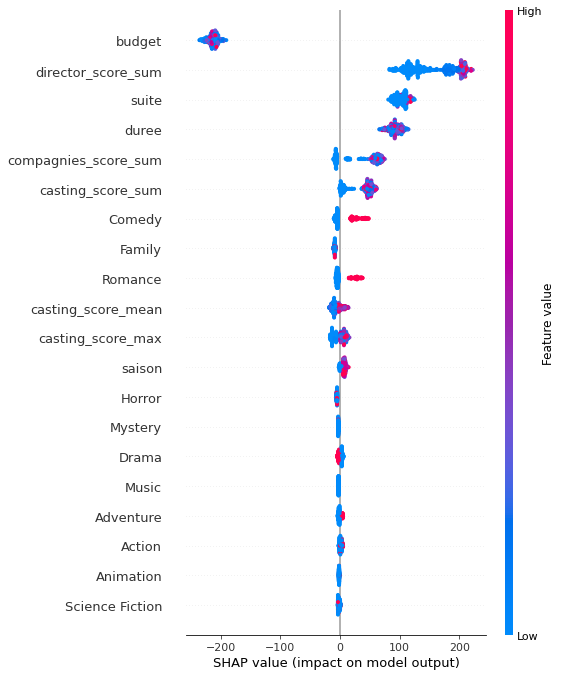

In [36]:
import shap

explainer = shap.explainers.Tree(regr)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

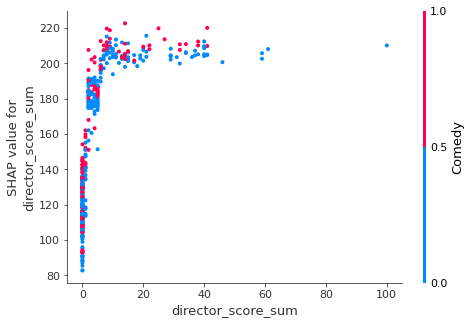

In [38]:
shap.dependence_plot('director_score_sum', shap_values, X_train)

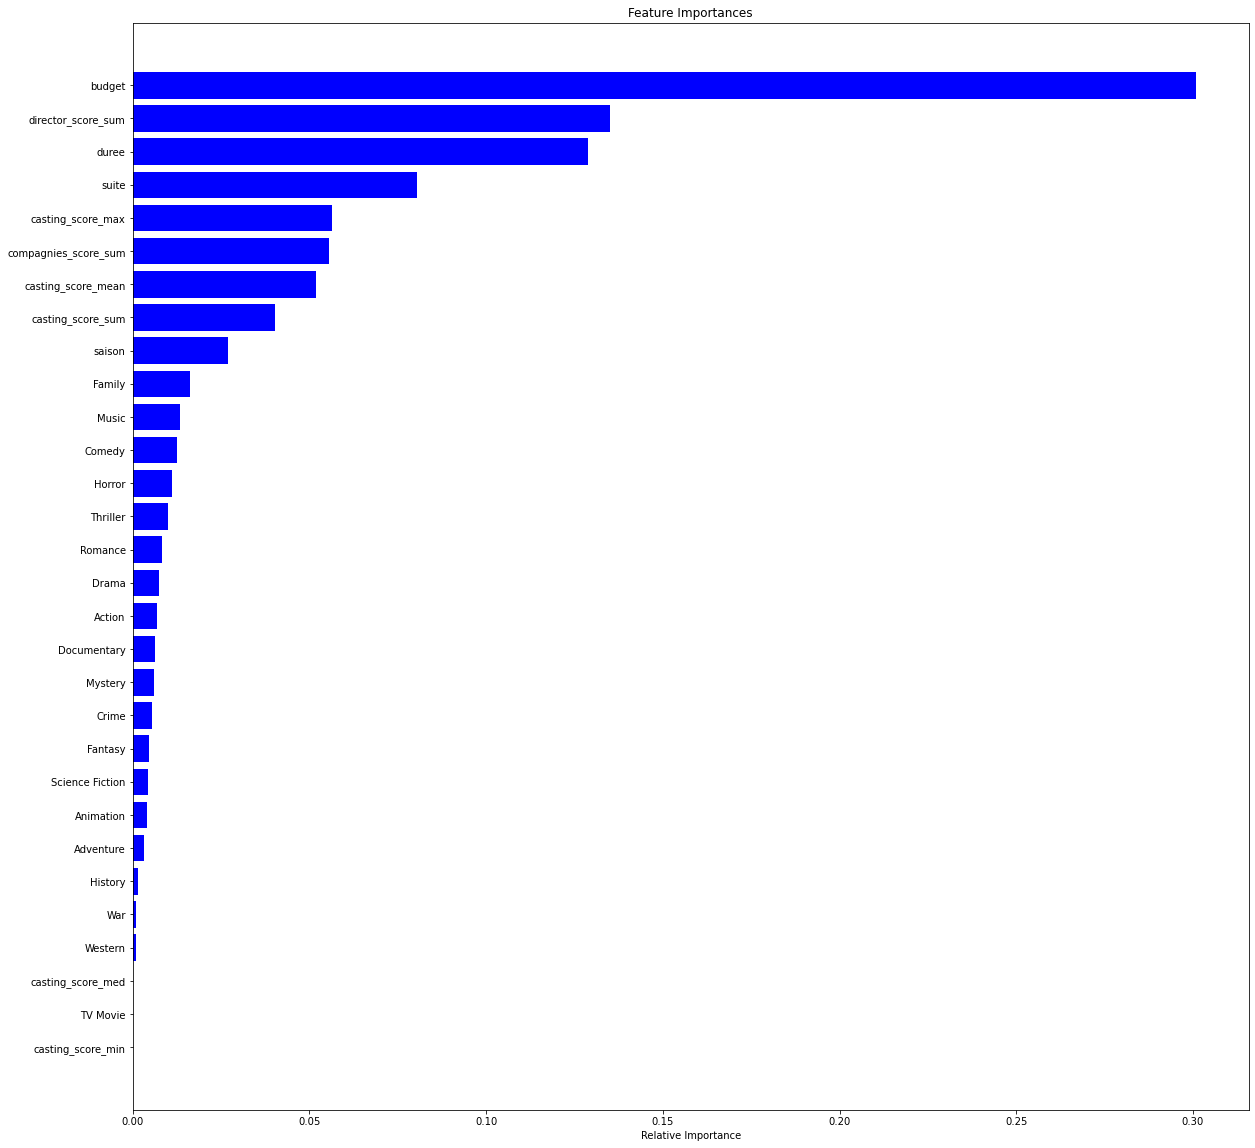

In [22]:
importances = regr.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.figure(figsize=(20,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
